In [1]:
import requests
from IPython.core.display import HTML
styles = requests.get("https://raw.githubusercontent.com/Harvard-IACS/2018-CS109A/master/content/styles/cs109.css").text
HTML(styles)

import pandas as pd
import time
import numpy as np
from sklearn.decomposition import PCA
import matplotlib
import matplotlib.pyplot as plt
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
import seaborn as sns
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LogisticRegressionCV
from sklearn.model_selection import cross_val_score
from sklearn.utils import resample
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.metrics import accuracy_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
import warnings

In [106]:
house_df = pd.read_csv('data/house_mean_imputation.csv')
#house_df = pd.read_csv('data/ready_to_use_dataset.csv')
house_df = house_df.drop_duplicates(['year', 'state', 'district', 'name'])
display(house_df.shape)
display(house_df.head())

(9974, 20)

,district,is_incumbent,name,party,percent,state,votes,won,year,first_time_elected,count_victories,unemployement_rate,is_presidential_year,president_can_be_re_elected,president_party,president_overall_avg_job_approval,last_D_house_seats,last_R_house_seats,last_house_majority,fundraising
0,District 1,0.0,Ratliff Boon,D,42.1,Indiana,4281,1,1824,1824.0,0,0.0,0.0,1.0,0,0.525667,200.179856,182.503597,R,552917.8375
1,District 1,1.0,Ratliff Boon,D,42.8,Indiana,5202,1,1826,1824.0,1,0.0,0.0,1.0,0,0.525667,200.179856,182.503597,R,552917.8375
2,District 1,1.0,Ratliff Boon,D,52.2,Indiana,7272,1,1828,1824.0,2,0.0,0.0,1.0,0,0.525667,200.179856,182.503597,R,552917.8375
3,District 1,0.0,John Law,D,49.1,Indiana,10868,0,1830,1860.0,0,0.0,0.0,1.0,0,0.525667,200.179856,182.503597,R,552917.8375
4,District 1,1.0,Ratliff Boon,D,50.9,Indiana,11280,1,1830,1824.0,3,0.0,0.0,1.0,0,0.525667,200.179856,182.503597,R,552917.8375


In [165]:
#plot
def plotCVscores(depths, scores_train, scores_train_CV, scores_train_CVstd, title, xlabel='Depth'):
    fig, ax = plt.subplots(1, 1, figsize=(15, 5))
    fig.suptitle(title, fontsize=24, y=1.0)
    ax.plot(depths, scores_train, label = 'Full training set')
    ax.plot(depths, scores_train_CV, label = 'Cross validation means')
    upper=np.array(scores_train_CV)+2*np.array(scores_train_CVstd)
    lower=np.array(scores_train_CV)-2*np.array(scores_train_CVstd)
    ax.fill_between(depths, lower, upper, color='chocolate', alpha='0.1')
    ax.set_xlabel(xlabel)
    ax.set_ylabel('Score')
    #ax.set(ylim=([0.95*min(lower),1.05*max(upper)])) #I guess this is the meaning of "set the y-axis to focus on the cross-validation performance."
    ax.set_xticks(depths)
    ax.legend();
def barplotScores(models_names, scores_train, scores_val, scores_val_mut_escl, baseline_accuracy):
    #plot
    fig, ax = plt.subplots(1, 1, figsize=(10, 5))
    fig.suptitle('Scores of all fitted models on training vs validation set', fontsize=24, y=1)
    ax.barh(models_names, scores_train, alpha=0.5, label='train set') 
    ax.barh(models_names, scores_val, alpha=0.5, label='val set')   
    ax.barh(models_names, scores_val_mut_escl, alpha=0.5, label='val set mut. excl.')  
    max_scores=np.maximum(np.maximum(np.array(scores_train),np.array(scores_val)),np.array(scores_val_mut_escl))
    for i, v in enumerate(max_scores):
        ax.text(v+0.005, i, '{:<.2%}'.format(v), color='black', fontsize=12)
        #ax.text(scores_val[i]+0.015, i, '{:.4}'.format(v), color='royalblue', fontsize=12)
    min_scores=np.minimum(np.minimum(np.array(scores_train),np.array(scores_val)),np.array(scores_val_mut_escl))
    for i, v in enumerate(min_scores):
        ax.text(v-0.03, i, '{:>.2%}'.format(v), color='white', fontsize=12)    
    ax.axvline(x=baseline_accuracy, c='g', label='baseline')
    #ax.text(baseline_accuracy, 0, '{:.2%}'.format(baseline_accuracy), color='green', horizontalalignment='center', verticalalignment='center', fontsize=12)
    ax.set_xlabel('Score')
    plt.xlim(baseline_accuracy*0.95,1)
    fig.legend(bbox_to_anchor=(1.25, 0.88));
def plotModelsScores(modelList, baseline_accuracy):
    models_names=[]
    scores_train=[] 
    scores_val=[] 
    scores_val_mut_escl=[]
    for model in modelList:
        models_names.append(model['name'])
        scores_train.append(model['score train'])
        scores_val.append(model['score validation'])
        scores_val_mut_escl.append(model['score val mut exclusive'])
    barplotScores(models_names, scores_train, scores_val, scores_val_mut_escl, baseline_accuracy)

In [ ]:
#plt.hist(house_df[house_df['first_time_elected']>0]['first_time_elected'])

In [82]:
#Actual seats repartition in the House of Representatives
display(house_df.loc[(house_df['year']==2018)][['last_D_house_seats', 'last_R_house_seats']].iloc[0])

last_D_house_seats    194.0
last_R_house_seats    241.0
Name: 9130, dtype: float64

In [83]:
#house_df2=house_df.set_index(['year', 'state', 'district', 'name']).dropna().copy()
#house_df2=house_df.dropna().copy()
#house_df2_districts=house_df2[['state','district']]
#house_df2=house_df2.drop('state', axis=1).drop('district', axis=1).drop('name', axis=1)
#house_df2['party']=house_df2['party'].replace(['D', 'R'], [0, 1])
#house_df2['president_party']=house_df2['president_party'].replace(['D', 'R'], [0, 1])
#house_df2['last_house_majority']=house_df2['last_house_majority'].replace(['D', 'R'], [0, 1])
#data_train, data_test=house_df2[house_df2['year']!=2018], house_df2[house_df2['year']==2018]

#x_train, y_train=data_train.drop('won', axis=1).drop('percent', axis=1).drop('votes', axis=1), data_train['won']
#x_test, y_test=data_test.drop('won', axis=1).drop('percent', axis=1).drop('votes', axis=1), data_test['won']
#def splitDf(df, year):
#    dfcopy=df.dropna().copy()
#    indexed_districts=dfcopy[['state','district']]
#    dfcopy=dfcopy.drop('state', axis=1).drop('district', axis=1).drop('name', axis=1).drop('percent', axis=1).drop('votes', axis=1)
#    data_train, data_test=dfcopy[dfcopy['year']!=year], dfcopy[dfcopy['year']==year]
#
#    x_train, y_train=data_train.drop('won', axis=1), data_train['won']
#    x_test, y_test=data_test.drop('won', axis=1), data_test['won']
#    return x_train, y_train, x_test, y_test, indexed_districts

In [154]:
def splitDf(df, year):
    dfcopy=df.dropna().copy()
    indexed_districts=dfcopy[['state','district']]
    dfcopy=dfcopy.drop('state', axis=1).drop('district', axis=1).drop('name', axis=1).drop('percent', axis=1).drop('votes', axis=1)
    data_train, data_test=dfcopy[dfcopy['year']!=year], dfcopy[dfcopy['year']==year]

    x_train, y_train=data_train.drop('won', axis=1), data_train['won']
    x_test, y_test=data_test.drop('won', axis=1), data_test['won']
    return x_train, y_train, x_test, y_test, indexed_districts

In [85]:
def deductPartisanship(trainData):
    #compute the prevalence of one party win against the other
    house_df_all_districts=trainData[(trainData['won']==1)].groupby(['state', 'district'])['party'].sum().reset_index(drop=False)
    house_df_all_districts['R_occurence']=house_df_all_districts['party'].str.count('R')/house_df_all_districts['party'].str.len()

    avgHistData=house_df_all_districts['party'].str.len().mean() #Average amount of historical data per district
    histDataThreshold=avgHistData/2

    #3=traditionally Republican district
    #2=traditionally Democratic district
    #1=swing district
    #0=Recent district (Not enough historical data)
    house_df_all_districts['partisanship']=(house_df_all_districts['party'].str.len()>=histDataThreshold)*(
                      (house_df_all_districts['R_occurence']>(2/3))*3
                    + (house_df_all_districts['R_occurence']<=(1/3))*2
                    + ((house_df_all_districts['R_occurence']>(1/3))
                      &(house_df_all_districts['R_occurence']<=(2/3)))*1
                    )
    return house_df_all_districts[['state', 'district', 'partisanship']]

def assignPartisanship(x_train, y_train, indexed_districts, x_test):
    train_df=x_train.copy()
    train_df['won']=y_train
    train_df=indexed_districts.join(train_df).dropna()
    test_df=indexed_districts.join(x_test.copy()).dropna()

    out_df=test_df.join(deductPartisanship(train_df).set_index(['state', 'district']), on=['state', 'district']).drop('state', axis=1).drop('district', axis=1)
    #display(out_df[out_df['partisanship'].isna()])
    return out_df.fillna(0)

In [275]:
def preprocess(x_train, y_train, indexed_districts, df):
    df_out=df.copy()
    
    #first_time_elected relative to election year and non-negative
    #df_out.loc[df_out['first_time_elected']>0, 'first_time_elected']=df_out['year']-df_out['first_time_elected']
    #df_out.loc[df_out['first_time_elected']<0, 'first_time_elected']=0
    df_out.drop('first_time_elected', axis=1)
               
    #Assign district partisanship
    df_out=assignPartisanship(x_train, y_train, indexed_districts, df_out)
    df_out=pd.get_dummies(df_out, columns=['partisanship'], drop_first=True)
    
    #calculate Log10 of fundraising
    df_out['Log10fundraising']=df_out['fundraising']
    df_out.loc[df_out['Log10fundraising']<=0, 'Log10fundraising']=np.NaN
    df_out['Log10fundraising']=np.log10(df_out['Log10fundraising']) #take the log10
    df_out.loc[df_out['Log10fundraising'].isna(), 'Log10fundraising']=0
    #drop linear fundraising
    df_out=df_out.drop('fundraising', axis=1)
    
    #replace 'D' and 'R' with 0 and 1 
    df_out['party']=df_out['party'].replace(['D', 'R'], [0, 1])
    df_out['president_party']=df_out['president_party'].replace(['D', 'R'], [0, 1])
    df_out['last_house_majority']=df_out['last_house_majority'].replace(['D', 'R'], [0, 1])
    
    #Ratio of R vs D seats before election. Percentage of opponent seats in House 
    df_out['last_R_vs_D_Seats']=df_out['last_R_house_seats']/(df_out['last_R_house_seats']+df_out['last_D_house_seats']) #1=100% R, 0=100% D
    df_out=df_out.drop('last_R_house_seats', axis=1).drop('last_D_house_seats', axis=1)
    
    #Percentage of own party seats in House. Non-linear interaction term (because of abs)
    df_out['last_own_party_Seats']=(1-df_out['party']-df_out['last_R_vs_D_Seats']).abs() #1=100% own seats, 0=100% opponent
    
    #drop year
    #df_out=df_out.drop('year', axis=1)
    
    return df_out

In [276]:
def MutuallyExclusivePredictions(model, x_train, x_test, y_train, y_test, indexed_districts):
    def Accuracy(y, y_pred):
        return np.sum(y == y_pred) / len(y)

    #predict results
    y_pred_train=model.predict(x_train)
    y_pred_test=model.predict(x_test)

    #calculate accuracy
    Accu_train=Accuracy(y_train, y_pred_train)
    Accu_val=Accuracy(y_test, y_pred_test)
    
    #At this stage, our predictions could lead to more than one winner per district (or none), but in reality they are mutually exclusive 
    #We will take the maximum prediction probabilities to be sure to have one and only one winner per district
    #predict probabilities
    y_pred_train=model.predict_proba(x_train)[:,1]
    y_pred_test=model.predict_proba(x_test)[:,1]

    #Add index to predictions from X set
    y_pred_train_df=pd.DataFrame(y_pred_train, index=x_train.index, columns=['abs_won_proba'])
    y_pred_test_df=pd.DataFrame(y_pred_test, index=x_test.index, columns=['abs_won_proba'])

    #Join district data, party and predictions by index
    districts_pred_train=indexed_districts.join(x_train[['party']]).join(y_pred_train_df).dropna()
    districts_pred_test=indexed_districts.join(x_test[['party']]).join(y_pred_test_df).dropna()

    #Group by district and aggregate predictions with max probability
    districts_pred_test_grouped=districts_pred_test.groupby(['state', 'district']).agg({'abs_won_proba':('max', 'sum')})
    districts_pred_test_grouped.columns = ['max_won_proba', 'sum_won_proba']
    districts_pred_test_grouped = districts_pred_test_grouped.reset_index(drop=False)

    #Create won_pred response variable (at this stage we have only the winner candidates)
    districts_pred_test_grouped['won_pred']=1

    #join district and party data with max predictions probabilities 
    out_df=districts_pred_test.join(districts_pred_test_grouped.set_index(['state', 'district', 'max_won_proba'])['won_pred'],on=['state', 'district', 'abs_won_proba']).fillna(0)

    #join district and party data with sum predictions probabilities 
    out_df=out_df.join(districts_pred_test_grouped.set_index(['state', 'district'])['sum_won_proba'],on=['state', 'district'])
    
    #calculate relative probability. That takes into account the predictions of the other candidates within the same district
    out_df['rel_won_proba']=out_df['abs_won_proba']/out_df['sum_won_proba']
    #display(out_df[(out_df['state']=='Louisiana')&(out_df['district']=='District 3')]) #&(out_df['year']==2018)])
    
    #check to have only and one only winner per district 
    districtWinners=out_df.groupby(['state', 'district'])['won_pred'].sum().reset_index(drop=False)
    NotJustOneWinner=districtWinners[districtWinners['won_pred']!=1]
    if (len(NotJustOneWinner)>0): 
        warnings.warn("{} districts have no winner or more than one winner".format(len(NotJustOneWinner), DeprecationWarning))
        display(districtWinners[districtWinners['won_pred']!=1])
        display(out_df[(out_df['state']==NotJustOneWinner.iloc[0]['state'])&(out_df['district']==NotJustOneWinner.iloc[0]['district'])])
        districts_x_test=indexed_districts.join(x_test).join(y_pred_test_df).dropna()
        display(districts_x_test[(districts_x_test['state']==NotJustOneWinner.iloc[0]['state'])&(districts_x_test['district']==NotJustOneWinner.iloc[0]['district'])])
        #mange conflicts: if more than one candidate have the same prediction probability, set all to zero
        #if they are all from the same party, though, set the first to one (we aim to predict party wins, not specific candidates)
        for state in NotJustOneWinner['state']:
            for district in NotJustOneWinner[NotJustOneWinner['state']==state]['district']:
                i=np.zeros(len(out_df.loc[(out_df['state']==state)&(out_df['district']==district)&(out_df['won_pred']==1), 'won_pred'])) 
                if (len(out_df.loc[(out_df['state']==state)&(out_df['district']==district)&(out_df['won_pred']==1), 'party'].unique())==1):
                    print('The conflict is from candidates from the same party, so we predict as winner in the district the first candidate of this party')
                    i[0]=1
                out_df.loc[(out_df['state']==state)&(out_df['district']==district)&(out_df['won_pred']==1), 'won_pred']=i
                #display(out_df.loc[(out_df['state']==state)&(out_df['district']==district), 'won_pred'])
    #assert len(NotJustOneWinner) == 0, "{} districts have no winner or more than one winner".format(len(NotJustOneWinner))
    
    #validation accuracy score
    Accu_val_2=Accuracy(y_test, out_df['won_pred'])
    #Accu_val_2=sum(out_df['won_pred']==y_test)/len(out_df)
    
    #display(out_df.head())
    
    return Accu_train, Accu_val, Accu_val_2, out_df.drop('sum_won_proba', axis=1)

In [277]:
#plot
def plotYearscores(years, scores_train, scores_train_CV, scores_CV_mutExcl, title, xlabel='Year'):
    fig, ax = plt.subplots(1, 1, figsize=(15, 5))
    fig.suptitle(title, fontsize=24, y=1.0)
    ax.plot(years, scores_train, label = 'Full training set')
    ax.plot(years, scores_train_CV, label = 'CV mean score')
    ax.plot(years, scores_CV_mutExcl, label = 'CV mean mutually exclusive score')
    ax.set_xlabel(xlabel)
    ax.set_ylabel('Score')
    ax.set_xticks(years)
    ax.legend();
    
def modelListTrain(modelList, train_data, years):
    for i in range(len(modelList)):
    #for i in [1]:
        model=modelList[i]
        #model=dict()
        #model['model']=modelType
        #list with training accuracy
        train_acc=[]
        #list with validation accuracy
        val_acc=[]
        #list with mutually exclusive validation accuracy
        val_acc_2=[]
        #list with uncertainties
        n_uncertain=[]
        for year in years:
            print('model: {}'.format(model['name']))
            print('year: {}'.format(year))
            #split dataset
            x_train, y_train, x_val, y_val, house_df_districts = splitDf(train_data, year)

            #preprocess
            x_train_preprocess=preprocess(x_train, y_train, house_df_districts, x_train)
            x_val_preprocess=preprocess(x_train, y_train, house_df_districts, x_val)

            #remove columns which are not in both datasets, like set(dataset1)^set(dataset2)
            x_train_preprocess=x_train_preprocess[list(x_val_preprocess)]
    
            #Standardize
            columns=list(x_train_preprocess.select_dtypes(include=['float']))
            scaler = StandardScaler().fit(x_train_preprocess[columns])
            x_train_standard=x_train_preprocess
            x_val_standard=x_val_preprocess
            x_train_standard.loc[:,columns]=scaler.transform(x_train_preprocess[columns])
            x_val_standard.loc[:,columns]=scaler.transform(x_val_preprocess[columns])
            #scaler = StandardScaler().fit(x_train_preprocess)
            #x_train_standard=scaler.transform(x_train_preprocess)
            #x_val_standard=scaler.transform(x_val_preprocess)
            
            #fit model
            #display(x_train_preprocess.head())
            fitted_model=model['model'].fit(x_train_preprocess, y_train)

            #generate predictions and calculate accuracy
            Accu_train, Accu_val, Accu_val_2, pred_df = MutuallyExclusivePredictions(fitted_model, x_train_preprocess, x_val_preprocess, y_train, y_val, house_df_districts)

            #store accuracy
            train_acc.append(Accu_train)
            val_acc.append(Accu_val)
            val_acc_2.append(Accu_val_2)

            #print accuracy scores
            print('Training accuracy: {:.2%}\nValidation accuracy: {:.2%}\nMutually exclusive validation accuracy: {:.2%}'.format(Accu_train, Accu_val, Accu_val_2))

            #print how many republican, how many democrat districts
            DEM=pred_df[(pred_df['won_pred']==1)&(pred_df['party']==0)]
            REP=pred_df[(pred_df['won_pred']==1)&(pred_df['party']==1)]
            print('N. Democrat districts: {}\nN. Republican districts: {}'.format(len(DEM), len(REP)))

            #print uncertainties
            uncertainties=pred_df[(pred_df['rel_won_proba']<0.8) & (pred_df['abs_won_proba']>0.5)]
            n_uncertainties=len(pred_df[(pred_df['rel_won_proba']<0.8) & (pred_df['abs_won_proba']>0.5)])
            n_uncertain.append(n_uncertainties)
            print('Uncertainties: {}\n'.format(n_uncertainties))
        title='Scores or model {} cross-validated through years'.format(modelList[i]['name'])
        plotYearscores(years, train_acc, val_acc, val_acc_2, title, xlabel='Year')
        modelList[i]['score train']=np.mean(train_acc)
        modelList[i]['score validation']=np.mean(val_acc)
        modelList[i]['score val mut exclusive']=np.mean(val_acc_2)
        modelList[i]['N. uncertainties']=np.mean(n_uncertain)
    display(modelList)

In [278]:
#one shot prediction
model=LogisticRegressionCV(cv=5, penalty='l2', max_iter=2500)

#split dataset
year=2018
x_train, y_train, x_test, y_test, house_df_districts = splitDf(house_df, year)

#preprocess
x_train_preprocess=preprocess(x_train, y_train, house_df_districts, x_train)
x_test_preprocess=preprocess(x_train, y_train, house_df_districts, x_test)

#fit model
#display(x_train_preprocess.head())
fitted_model=model.fit(x_train_preprocess, y_train)

#generate predictions and calculate accuracy
Accu_train, Accu_val, Accu_val_2, pred_df = MutuallyExclusivePredictions(fitted_model, x_train_preprocess, x_test_preprocess, y_train, y_test, house_df_districts)

#print accuracy scores
print('Training accuracy: {:.2%}\nValidation accuracy: {:.2%}\nMutually exclusive validation accuracy: {:.2%}\n'.format(Accu_train, Accu_val, Accu_val_2))

#print how many republican, how many democrat districts
DEM=pred_df[(pred_df['won_pred']==1)&(pred_df['party']==0)]
REP=pred_df[(pred_df['won_pred']==1)&(pred_df['party']==1)]
print('N. Democrat districts: {}\nN. Republican districts: {}'.format(len(DEM), len(REP)))

#print uncertainties
#display(pred_df[(pred_df['rel_won_proba']<0.8) & (pred_df['abs_won_proba']>0.5)])

Training accuracy: 97.38%
Validation accuracy: 97.02%
Mutually exclusive validation accuracy: 99.76%

N. Democrat districts: 229
N. Republican districts: 206


In [291]:
#test set on 2018 data, train set on previous data
#train_data, test_data = house_df[house_df['year']!=2018], house_df[house_df['year']==2018]
train_data, test_data = house_df[(house_df['year']>=1868)&(house_df['year']!=2018)], house_df[house_df['year']==2018]

In [292]:
#Years lists
Midterm_recent_years=2014-4*np.arange(10)
All_recent_years=2016-2*np.arange(20)
display(Midterm_recent_years)
display(All_recent_years)

array([2014, 2010, 2006, 2002, 1998, 1994, 1990, 1986, 1982, 1978])

array([2016, 2014, 2012, 2010, 2008, 2006, 2004, 2002, 2000, 1998, 1996,
       1994, 1992, 1990, 1988, 1986, 1984, 1982, 1980, 1978])

In [293]:
modelList=[]
model=dict()
model['name']='Logistic Regression CV=5'
model['model']=LogisticRegressionCV(cv=5, penalty='l2', max_iter=2500)
modelList.append(model)
#model=dict()
#model['name']='k-NN, k=4'
#model['model']=KNeighborsClassifier(n_neighbors=4)
#modelList.append(model)
model=dict()
model['name']='LDA'
model['model']=LinearDiscriminantAnalysis(store_covariance=True)
modelList.append(model)
model=dict()
model['name']='QDA'
model['model']=QuadraticDiscriminantAnalysis(store_covariance=True)
modelList.append(model)

years=Midterm_recent_years
    

model: Logistic Regression CV=5
year: 2014
Training accuracy: 97.31%
Validation accuracy: 98.25%
Mutually exclusive validation accuracy: 97.00%
N. Democrat districts: 195
N. Republican districts: 235
Uncertainties: 28

model: Logistic Regression CV=5
year: 2010
Training accuracy: 97.56%
Validation accuracy: 94.70%
Mutually exclusive validation accuracy: 90.53%
N. Democrat districts: 152
N. Republican districts: 123
Uncertainties: 56

model: Logistic Regression CV=5
year: 2006
Training accuracy: 97.41%
Validation accuracy: 97.09%
Mutually exclusive validation accuracy: 95.73%
N. Democrat districts: 139
N. Republican districts: 133
Uncertainties: 30

model: Logistic Regression CV=5
year: 2002
Training accuracy: 97.32%
Validation accuracy: 98.84%
Mutually exclusive validation accuracy: 99.07%
N. Democrat districts: 112
N. Republican districts: 121
Uncertainties: 10

model: Logistic Regression CV=5
year: 1998
Training accuracy: 97.34%
Validation accuracy: 99.57%
Mutually exclusive validati

[{'name': 'Logistic Regression CV=5',
  'model': LogisticRegressionCV(Cs=10, class_weight=None, cv=5, dual=False,
             fit_intercept=True, intercept_scaling=1.0, max_iter=2500,
             multi_class='warn', n_jobs=None, penalty='l2',
             random_state=None, refit=True, scoring=None, solver='lbfgs',
             tol=0.0001, verbose=0),
  'score train': 0.9739065565192526,
  'score validation': 0.9754435848268559,
  'score val mut exclusive': 0.9644506757430518,
  'N. uncertainties': 16.0},
 {'name': 'LDA',
  'model': LinearDiscriminantAnalysis(n_components=None, priors=None, shrinkage=None,
                solver='svd', store_covariance=True, tol=0.0001),
  'score train': 0.9739065565192526,
  'score validation': 0.9754435848268559,
  'score val mut exclusive': 0.966583849586752,
  'N. uncertainties': 16.0},
 {'name': 'QDA',
  'model': QuadraticDiscriminantAnalysis(priors=None, reg_param=0.0,
                 store_covariance=True, store_covariances=None, tol=0.0001),

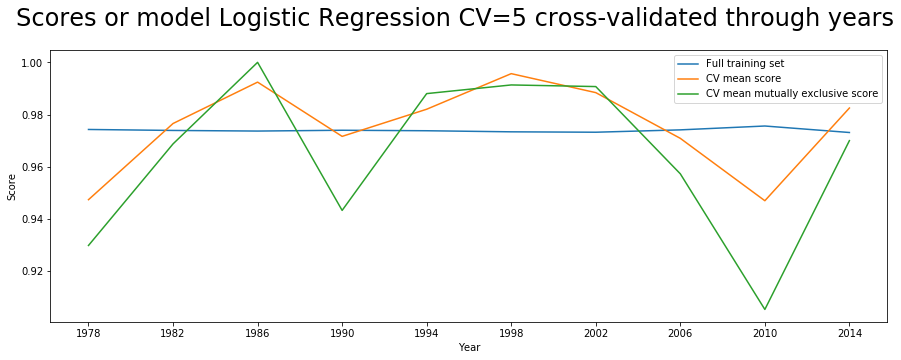

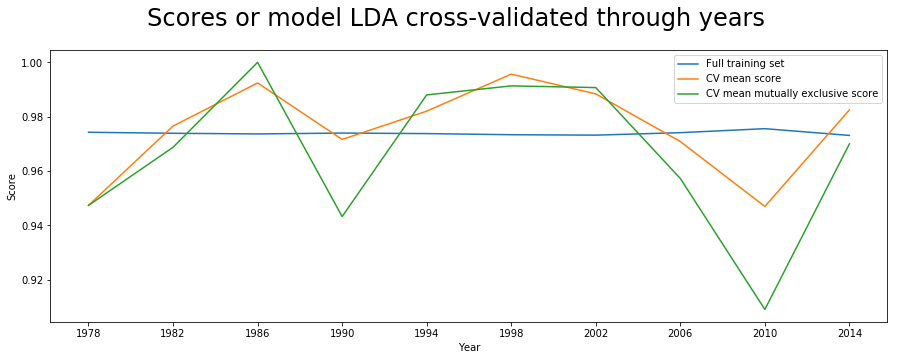

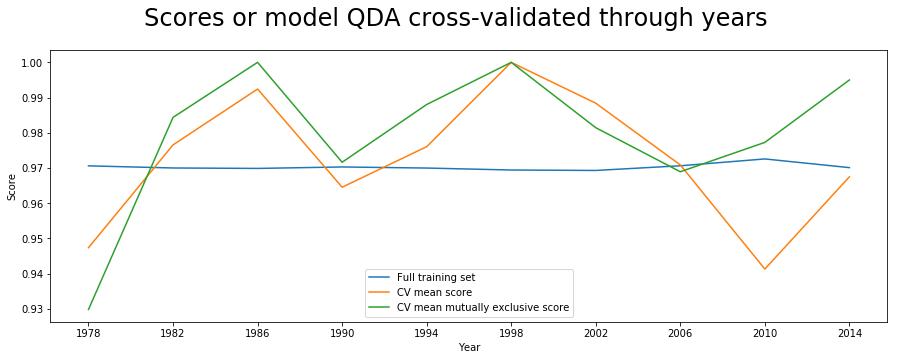

In [294]:
modelListTrain(modelList, train_data, years)

In [ ]:
#find best depth for decision tree
#years=Midterm_recent_years
years=All_recent_years[:5]
for year in years:
    #split dataset
    x_train, y_train, x_val, y_val, house_df_districts = splitDf(train_data, year)

    #preprocess
    x_train_preprocess=preprocess(x_train, y_train, house_df_districts, x_train)
    x_val_preprocess=preprocess(x_train, y_train, house_df_districts, x_val)

    #remove columns which are not in both datasets, like set(dataset1)^set(dataset2)
    x_train_preprocess=x_train_preprocess[list(x_val_preprocess)]

    #fit model
    depths=list(range(1,21)) #set (maximum) tree depths 1, 2, 3, ..., 20
    scores_train = []
    scores_train_CV = []
    scores_train_CVstd = []
    for depth in depths:
        dt = DecisionTreeClassifier(max_depth = depth)
        scores = cross_val_score(estimator=dt, X=x_train_preprocess, y=y_train, cv=5)
        scores_train_CV.append(scores.mean()) #cross-validated score
        scores_train_CVstd.append(scores.std()) #cross-validated score
        dt.fit(x_train_preprocess, y_train)
        scores_train.append(dt.score(x_train_preprocess, y_train)) #score on training data

    #plot
    title='{}. Single decision tree score on full training vs CV=5 set'.format(year)
    plotCVscores(depths, scores_train, scores_train_CV, scores_train_CVstd, title)  

In [ ]:
#Add decision tree model
max_depth=4
model=dict()
model['name']='Decision Tree, depth={}'.format(max_depth)
model['model']=DecisionTreeClassifier(max_depth = max_depth)
modelList.append(model)
max_depth=5
model=dict()
model['name']='Decision Tree, depth={}'.format(max_depth)
model['model']=DecisionTreeClassifier(max_depth = max_depth)
modelList.append(model)

In [ ]:
modelListTrain(modelList[-2:], train_data, years)

In [ ]:
baseline_accuracy=0.7793 #TO BE UPDATED
plotModelsScores(modelList, baseline_accuracy)

In [ ]:
#house_df[(house_df['state']=='Louisiana')&(house_df['district']=='District 3')&(house_df['year']==2018)]
#house_df[(house_df['state']=='California')&(house_df['district']=='District 17')&(house_df['year']==2014)]
house_df[(house_df['state']=='Colorado')&(house_df['district']=='District 3')&(house_df['year']==2014)]
#house_df.iloc[[9600, 9801, 9813, 9904], :] #9600, 9801, 9813, 9904

In [ ]:
(house_df[(house_df['year']==1998)]).head()

In [ ]:
plt.hist(pred_df['abs_won_proba'])

In [ ]:
plt.hist(pred_df['rel_won_proba'])